# Hurma Tanıma Sistemi

In [1]:
ls '/kaggle/input/date-fruit-image-dataset-in-controlled-environment'

 Ajwa/     Medjool/  'Nabtat Ali'/   Shaishe/   Sugaey/
 Galaxy/   Meneifi/   Rutab/         Sokari/


In [3]:
# Kütüphaneleri içe aktar
import numpy as np
import pandas as pd
from pathlib import Path
import os.path
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.preprocessing.image import load_img,img_to_array
print("tf versiyon:", tf.__version__)
import warnings
warnings.filterwarnings('ignore')

tf versiyon: 2.15.0


In [4]:
#Dosya yolu ve etiketlerden dataframe oluşturma fonksiyonu, 
#her bir klasor içine girip dosya isimlerini alıp df içine atıyor
def create_dataset(folders,path):
    data = {'imgpath': [], 'labels': []}
    for folder in folders:
        folderpath = os.path.join(path, folder)
        files = os.listdir(folderpath)
        
        for file in files:
            filepath = os.path.join(folderpath, file)
            data['imgpath'].append(filepath)
            data['labels'].append(folder)

    dataset = pd.DataFrame(data)
    return dataset

In [5]:
# Veri seti yolu ve klasör adları ile data frame oluştur
path1 = '/kaggle/input/date-fruit-image-dataset-in-controlled-environment'
folders1 = ['Ajwa','Medjool', 'Nabtat Ali',   'Shaishe',   
            'Sugaey','Galaxy', 'Meneifi','Rutab','Sokari'] 
df=create_dataset(folders1,path1)
df.head()

,imgpath,labels
0,/kaggle/input/date-fruit-image-dataset-in-cont...,Ajwa
1,/kaggle/input/date-fruit-image-dataset-in-cont...,Ajwa
2,/kaggle/input/date-fruit-image-dataset-in-cont...,Ajwa
3,/kaggle/input/date-fruit-image-dataset-in-cont...,Ajwa
4,/kaggle/input/date-fruit-image-dataset-in-cont...,Ajwa


In [6]:
# Veri seti bilgileri
print('-- Veri seti bilgileri --\n')
print(f'Görsel Sayısı: {df.shape[0]}\n')
print(f'Etiket sayısı: {len(df.labels.unique())}\n')
print(f'Etiketler {df.labels.unique()}')

-- Veri seti bilgileri --

Görsel Sayısı: 1658

Etiket sayısı: 9

Etiketler ['Ajwa' 'Medjool' 'Nabtat Ali' 'Shaishe' 'Sugaey' 'Galaxy' 'Meneifi'
 'Rutab' 'Sokari']


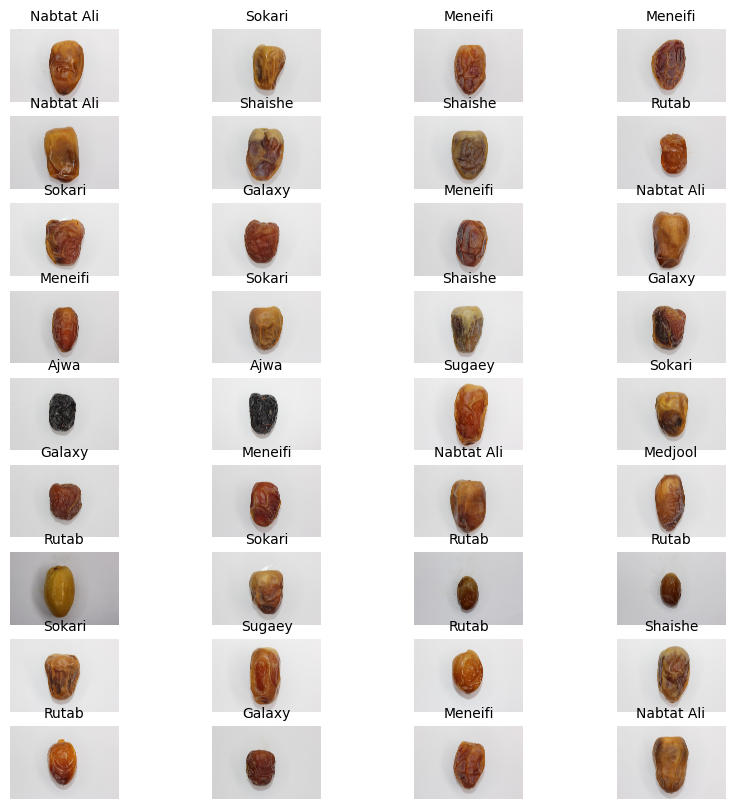

In [7]:
# Veri Görselleştirme
import random
import matplotlib.gridspec as gridspec
from PIL import Image
rows = 9
cols = 4

selected_indices = random.sample(range(len(df)), rows * cols)

fig, axes = plt.subplots(rows, cols, figsize = (10, 10))
gs = gridspec.GridSpec(rows, cols, wspace = 0.0, hspace = 0.0)

for i, idx in enumerate(selected_indices):
    row = i // cols
    col = i % cols
    img_path = df['imgpath'].iloc[idx]
    label = df['labels'].iloc[idx]
    img = Image.open(img_path)
    axes[row, col].imshow(img)
    axes[row, col].axis('off')
    axes[row, col].set_title(label, fontsize = 10)

plt.show()

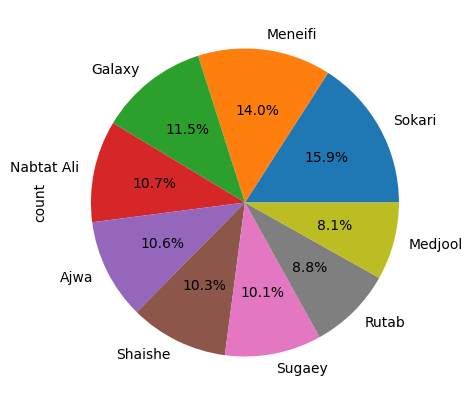

In [8]:
# pie plot label distribution
df.labels.value_counts().plot(kind='pie',autopct='%1.1f%%',figsize=(5,5));

In [9]:
from sklearn.model_selection import train_test_split

# Veri setini etiketlere göre bölme
train_df, test_df = train_test_split(df, test_size=0.2, random_state=42, stratify=df['labels'])
test_df, val_df = train_test_split(test_df, test_size=0.5, random_state=42, stratify=test_df['labels'])

train_df.shape, val_df.shape, test_df.shape

((1326, 2), (166, 2), (166, 2))

#VERİ ÖN İŞLEME

#ImageDataGenerator - Pikselleri sayıya çeviriyor.


In [10]:
%%time
# görsel ön işleme ve generator
from tensorflow.keras.preprocessing.image import ImageDataGenerator
seed = 42 #random state=42
batch_size = 64
img_size = (224, 224)

generator = ImageDataGenerator(rescale = 1./255)

train_data = generator.flow_from_dataframe(train_df, x_col = 'imgpath', y_col = 'labels', 
                                           color_mode = 'rgb', class_mode = 'categorical', 
                                           batch_size = batch_size, target_size = img_size, 
                                           shuffle = True, seed = seed)

val_data = generator.flow_from_dataframe(val_df, x_col = 'imgpath', y_col = 'labels', 
                                         color_mode = 'rgb', class_mode = 'categorical', 
                                         batch_size = batch_size, target_size = img_size, 
                                         shuffle = False)

test_data = generator.flow_from_dataframe(test_df, x_col = 'imgpath', y_col = 'labels', 
                                          color_mode = 'rgb', class_mode = 'categorical', 
                                          batch_size = batch_size, target_size = img_size, 
                                          shuffle = False)

Found 1326 validated image filenames belonging to 9 classes.
Found 166 validated image filenames belonging to 9 classes.
Found 166 validated image filenames belonging to 9 classes.
CPU times: user 69.6 ms, sys: 66.2 ms, total: 136 ms
Wall time: 1.03 s


In [11]:
#1326 eğitim dosyası

## Model Oluşturma

In [11]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense
from tensorflow.keras.losses import CategoricalCrossentropy

model = Sequential()
model.add(Input(shape=(224, 224, 3))) #giriş katmanı-giriş değeri 224,224 pixel, 3 boyutlu - RGB
model.add(Conv2D(32, kernel_size=(3, 3), activation='relu')) #Aktivasyon fonksiyonları 
model.add(MaxPooling2D(pool_size=(2, 2))) #CNN network - layers
model.add(Conv2D(64, kernel_size=(3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(128, kernel_size=(3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(256, kernel_size=(3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dense(9, activation='softmax'))  # 9 kategori

# Modelin derlenmesi
model.compile(optimizer='adam', loss=CategoricalCrossentropy(), metrics=['accuracy'])
#kategorik etiketler varsa loss = 'CategoricalCrossentropy()' ne kadar doğru tahmin edilmiş

In [12]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 222, 222, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 111, 111, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 109, 109, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 54, 54, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 52, 52, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 26, 26, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 24, 24, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 12, 12, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 36864)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     4,718,720 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 9)              │         1,161 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,108,297 (19.49 MB)

 Trainable params: 5,108,297 (19.49 MB)

 Non-trainable params: 0 (0.00 B)

In [17]:
%%time
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
# En düşük loss değerinde eğitimin durmasını sağla
model_es = EarlyStopping(monitor = 'val_loss', mode = 'min', patience = 2, restore_best_weights = True)
model_rlr = ReduceLROnPlateau(monitor = 'val_loss', factor = 0.2, patience = 1, mode = 'min')

history = model.fit(train_data, validation_data = val_data, 
                    epochs = 20, callbacks = [model_es, model_rlr])
#epochs veri setini baştan sona 20 defa kullan
#bachsize veriyi 50'şer 50'şer ver

Epoch 1/20
21/21 ━━━━━━━━━━━━━━━━━━━━ 214s 8s/step - accuracy: 0.9278 - loss: 0.2282 - val_accuracy: 0.9096 - val_loss: 0.2737 - learning_rate: 2.0000e-04
Epoch 2/20
21/21 ━━━━━━━━━━━━━━━━━━━━ 194s 7s/step - accuracy: 0.9506 - loss: 0.2021 - val_accuracy: 0.9096 - val_loss: 0.2595 - learning_rate: 2.0000e-04
Epoch 3/20
21/21 ━━━━━━━━━━━━━━━━━━━━ 189s 7s/step - accuracy: 0.9405 - loss: 0.1865 - val_accuracy: 0.8916 - val_loss: 0.3038 - learning_rate: 2.0000e-04
Epoch 4/20
21/21 ━━━━━━━━━━━━━━━━━━━━ 203s 7s/step - accuracy: 0.9432 - loss: 0.1770 - val_accuracy: 0.9277 - val_loss: 0.2607 - learning_rate: 4.0000e-05
CPU times: user 28min 23s, sys: 4min 3s, total: 32min 26s
Wall time: 13min 31s


In [18]:
# Model değerlendirme
test_results = model.evaluate(test_data, verbose = 0)

print(f'Test Loss: {test_results[0]:.5f}')
print(f'Test Accuracy: {test_results[1]} * 100')

Test Loss: 0.30116
Test Accuracy: 0.9096385836601257 * 100


In [ ]:
#Modeli kaydet
model.save('/kaggle/working/date_fruit')